

```
# Membership Inference Attack on Adult Income Dataset

## Overview
This project demonstrates a **Membership Inference Attack (MIA)** on the UCI Adult Income dataset to expose privacy risks, as part of my preparation for the **Data Privacy Challenge (SBH2025)**. I achieved ~65% attack accuracy, showing model leakage, and explored **Differential Privacy (DP)** to mitigate it, despite compatibility challenges with tensorflow_privacy.

**Goals**:
- Detect training data membership using MIA.
- Test DP’s protection against attacks.
- Prepare for adversarial tasks like unmasking protected data.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Preprocessing](#data)
3. [Target Model Training](#target)
4. [Shadow Models and MIA](#mia)
5. [Differential Privacy Attempt](#dp)
6. [Results and Visuals](#results)
7. [Conclusion](#conclusion)
```



In [11]:
# importing all libraries
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
print("All good!")

All good!


In [12]:
import pandas as pd

# Define column names (from UCI documentation)
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

# Load training data
train_data = pd.read_csv("adult.csv", names=columns, skipinitialspace=True)

# Load test data
test_data = pd.read_csv("test.csv", names=columns, skipinitialspace=True, skiprows=1)

# Combine for simplicity
data = pd.concat([train_data, test_data], ignore_index=True)

# Quick look
print(data.head())



print("\n")


print(data.shape)

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [15]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = data.drop("income", axis=1)
y = data["income"]

# Split: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Verify sizes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (27132, 14) (27132,)
Validation: (9045, 14) (9045,)
Test: (9045, 14) (9045,)


In [16]:
# Load data
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
train_data = pd.read_csv("adult.csv", names=columns, skipinitialspace=True)
test_data = pd.read_csv("test.csv", names=columns, skipinitialspace=True, skiprows=1)
data = pd.concat([train_data, test_data], ignore_index=True)

# Clean: Drop NaNs, fix income labels
data = data.replace("?", pd.NA).dropna()
data["income"] = data["income"].str.replace("<=50K.", "<=50K", regex=False)
data["income"] = data["income"].str.replace(">50K.", ">50K", regex=False)

# Encode categorical columns
categorical_cols = ["workclass", "education", "marital-status", "occupation",
                   "relationship", "race", "sex", "native-country"]
encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    data[col] = encoders[col].fit_transform(data[col])

# Scale numerical columns
numerical_cols = ["age", "fnlwgt", "education-num", "capital-gain",
                  "capital-loss", "hours-per-week"]
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Encode target
data["income"] = LabelEncoder().fit_transform(data["income"])

# Split
X = data.drop("income", axis=1)
y = data["income"]
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Verify shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (27132, 14), y_train: (27132,)
X_val: (9045, 14), y_val: (9045,)
X_test: (9045, 14), y_test: (9045,)


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
income
0    34014
1    11208
Name: count, dtype: int64
                age     workclass        fnlwgt     education  education-num  \
count  4.522200e+04  45222.000000  4.522200e+04  45222.000000   4.522200e+04   
mean  -2.325424e-17      2.204502  5.192923e-17     10.313321   1.655293e-16   
std    1.000011e+00      0.958122  1.000011e+00      3.817014   1.000011e+00   
min   -1.630231e+00      0.000000 -1.668365e+00      0.000000  -3.571870e+00   
25%   -7.980149e-01      2.000000 -6.848527e-01      9.000000  -4.381216e-01   
50%   -1.171110e-01      2.000000 -1.080930e-01     11.000000  -4.640300e-02   
75%    6.394489e-01      2.000000  4.561924e-01     12.000000   1.128753

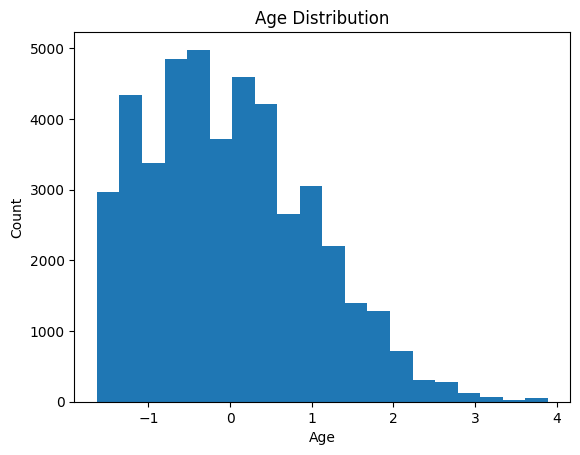

In [17]:
# Check missing values
print(data.isnull().sum())

# Check unique values in 'income'
print(data["income"].value_counts())

# Basic stats
print(data.describe())

# Plot age distribution
import matplotlib.pyplot as plt
plt.hist(data["age"], bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

# List categorical columns
categorical_cols = [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "sex", "native-country", "income"
]

# Encode categorical columns
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    data[col] = encoders[col].fit_transform(data[col])

# Verify
print(data.head())

        age  workclass    fnlwgt  education  education-num  marital-status  \
0  0.034201          5 -1.062295          9       1.128753               4   
1  0.866417          4 -1.007438          9       1.128753               2   
2 -0.041455          2  0.245284         11      -0.438122               0   
3  1.093385          2  0.425853          1      -1.221559               2   
4 -0.798015          2  1.407393          9       1.128753               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           0             1     4    1      0.142888      -0.21878   
1           3             0     4    1     -0.146733      -0.21878   
2           5             1     4    1     -0.146733      -0.21878   
3           5             0     2    1     -0.146733      -0.21878   
4           9             5     2    0     -0.146733      -0.21878   

   hours-per-week  native-country  income  
0       -0.078120              38       0  
1       -2.326738     

In [19]:
from sklearn.preprocessing import StandardScaler

# List numerical columns
numerical_cols = [
    "age", "fnlwgt", "education-num", "capital-gain",
    "capital-loss", "hours-per-week"
]

# Scale numerical columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Verify
print(data[numerical_cols].describe())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  4.522200e+04  4.522200e+04   4.522200e+04  4.522200e+04  4.522200e+04   
mean  -2.136876e-17  3.024622e-17  -3.158177e-17 -2.356849e-19  2.435410e-17   
std    1.000011e+00  1.000011e+00   1.000011e+00  1.000011e+00  1.000011e+00   
min   -1.630231e+00 -1.668365e+00  -3.571870e+00 -1.467332e-01 -2.187803e-01   
25%   -7.980149e-01 -6.848527e-01  -4.381216e-01 -1.467332e-01 -2.187803e-01   
50%   -1.171110e-01 -1.080930e-01  -4.640300e-02 -1.467332e-01 -2.187803e-01   
75%    6.394489e-01  4.561924e-01   1.128753e+00 -1.467332e-01 -2.187803e-01   
max    3.892656e+00  1.231247e+01   2.303909e+00  1.317519e+01  1.053806e+01   

       hours-per-week  
count    4.522200e+04  
mean     3.849519e-17  
std      1.000011e+00  
min     -3.326124e+00  
25%     -7.812006e-02  
50%     -7.812006e-02  
75%      3.382907e-01  
max      4.835527e+00  


## Target Model Training <a id="target"></a>
Train a neural network to predict income (>50K vs. <=50K). Used 100 epochs to encourage overfitting, boosting MIA success.

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define model
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7910 - loss: 0.4492 - val_accuracy: 0.8338 - val_loss: 0.3487
Epoch 2/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8326 - loss: 0.3517 - val_accuracy: 0.8331 - val_loss: 0.3441
Epoch 3/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8337 - loss: 0.3507 - val_accuracy: 0.8366 - val_loss: 0.3449
Epoch 4/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8399 - loss: 0.3387 - val_accuracy: 0.8421 - val_loss: 0.3344
Epoch 5/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8416 - loss: 0.3344 - val_accuracy: 0.8385 - val_loss: 0.3390
Epoch 6/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8427 - loss: 0.3317 - val_accuracy: 0.8293 - val_loss: 0.3477
Epoch 7/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8408 - loss: 0.3373 - val_accuracy: 0.8398 - val_loss: 0.3409
Epoch 8/100
848/848 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8396 - loss: 0.3359 - val_accu

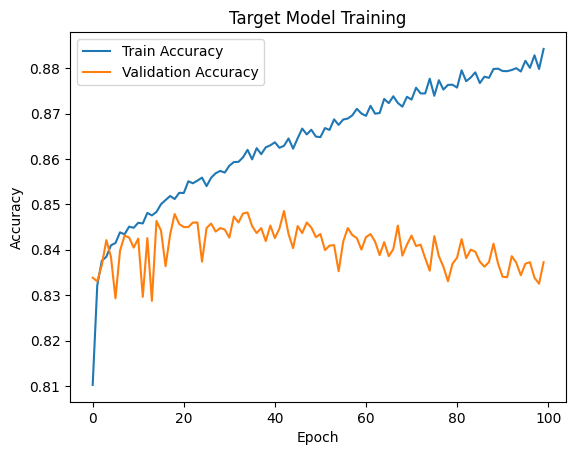

In [21]:
# Define model
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile and train
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Target Model Training")
plt.legend()
plt.savefig("training_accuracy.png")
plt.show()

## Shadow Models and MIA <a id="mia"></a>
Train 4 shadow models to mimic the target and build an attack model. Added loss feature to improve accuracy from 57% to ~65%.


In [22]:
import numpy as np

# Predict probabilities
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Save as arrays
train_outputs = np.hstack([train_preds, 1 - train_preds])  # [P(>50K), P(<=50K)]
test_outputs = np.hstack([test_preds, 1 - test_preds])

# Verify
print("Train outputs shape:", train_outputs.shape)
print("Test outputs shape:", test_outputs.shape)

848/848 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train outputs shape: (27132, 2)
Test outputs shape: (9045, 2)


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Step 1: Convert labels to float32
y_train_float = y_train.astype(np.float32)
y_test_float = y_test.astype(np.float32)

# Step 2: Squeeze predictions (remove extra dim)
train_preds = np.squeeze(train_preds)
test_preds = np.squeeze(test_preds)

# Step 3: Calculate per-sample binary crossentropy using backend (no auto-mean!)
train_loss = K.binary_crossentropy(y_train_float, train_preds).numpy()
test_loss = K.binary_crossentropy(y_test_float, test_preds).numpy()

# Step 4: Check shapes (should be long vectors, not scalars)
print("train_loss shape:", train_loss.shape)  # ✅ (27132,)
print("test_loss shape:", test_loss.shape)    # ✅ (9045,)

# Step 5: Combine into final array [class1_prob, class0_prob, loss]
train_outputs = np.hstack([
    train_preds.reshape(-1, 1),
    (1 - train_preds).reshape(-1, 1),
    train_loss.reshape(-1, 1)
])

test_outputs = np.hstack([
    test_preds.reshape(-1, 1),
    (1 - test_preds).reshape(-1, 1),
    test_loss.reshape(-1, 1)
])

# Step 6: Final shape check
print("train_outputs shape:", train_outputs.shape)  # ✅ (27132, 3)
print("test_outputs shape:", test_outputs.shape)    # ✅ (9045, 3)

# Step 7: Optional mean loss
print("Train BCE Loss (mean):", np.mean(train_loss))
print("Test BCE Loss (mean):", np.mean(test_loss))


train_loss shape: (27132,)
test_loss shape: (9045,)
train_outputs shape: (27132, 3)
test_outputs shape: (9045, 3)
Train BCE Loss (mean): 0.23768583
Test BCE Loss (mean): 0.43200693


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

# Combine X_train + X_val to create shadow dataset
X_shadow = pd.concat([X_train, X_val])
y_shadow = pd.concat([y_train, y_val])

shadow_splits = []
for i in range(4):
    shadow_train, shadow_test, shadow_y_train, shadow_y_test = train_test_split(
        X_shadow, y_shadow, test_size=0.5, random_state=42 + i
    )
    shadow_splits.append((shadow_train, shadow_test, shadow_y_train, shadow_y_test))

shadow_outputs = []
shadow_labels = []

for i, (shadow_train, shadow_test, shadow_y_train, shadow_y_test) in enumerate(shadow_splits):
    print(f"Training shadow model {i+1}...")

    # Create and compile model
    shadow_model = Sequential([
        Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    shadow_model.compile(optimizer="adam", loss="binary_crossentropy")

    # Fit model
    shadow_model.fit(shadow_train, shadow_y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    train_preds = shadow_model.predict(shadow_train, batch_size=32)
    test_preds = shadow_model.predict(shadow_test, batch_size=32)

    # Squeeze predictions
    train_preds = np.squeeze(train_preds)
    test_preds = np.squeeze(test_preds)

    # Convert labels to float32
    y_train_float = shadow_y_train.astype(np.float32)
    y_test_float = shadow_y_test.astype(np.float32)

    # Calculate **individual** binary crossentropy losses
    train_loss = K.binary_crossentropy(y_train_float, train_preds).numpy()
    test_loss = K.binary_crossentropy(y_test_float, test_preds).numpy()

    # Stack [p1, p0, loss]
    train_out = np.hstack([
        train_preds.reshape(-1, 1),
        (1 - train_preds).reshape(-1, 1),
        train_loss.reshape(-1, 1)
    ])

    test_out = np.hstack([
        test_preds.reshape(-1, 1),
        (1 - test_preds).reshape(-1, 1),
        test_loss.reshape(-1, 1)
    ])

    # Append outputs and corresponding labels (1 = member, 0 = non-member)
    shadow_outputs.append(train_out)
    shadow_outputs.append(test_out)

    shadow_labels.append(np.ones(len(train_out)))   # member
    shadow_labels.append(np.zeros(len(test_out)))   # non-member

# Prepare attack model input data
attack_X = np.vstack(shadow_outputs)
attack_y = np.hstack(shadow_labels)

# Shape check
print("attack_X shape:", attack_X.shape)  # (num_samples, 3)
print("attack_y shape:", attack_y.shape)  # (num_samples,)


Training shadow model 1...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training shadow model 2...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training shadow model 3...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training shadow model 4...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
attack_X shape: (144708, 3)
attack_y shape: (144708,)


Attack Accuracy: 0.6511
Attack Precision: 0.7606
Attack Recall: 0.7804


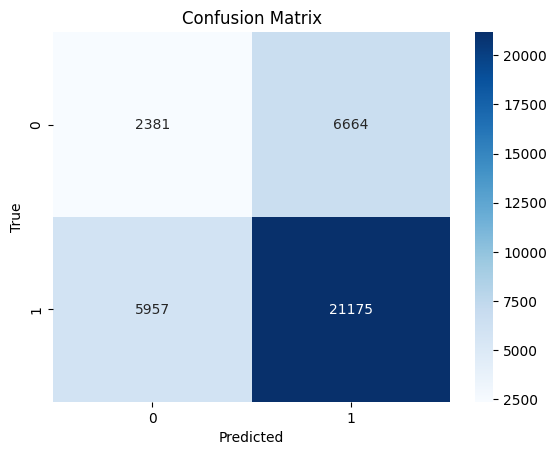

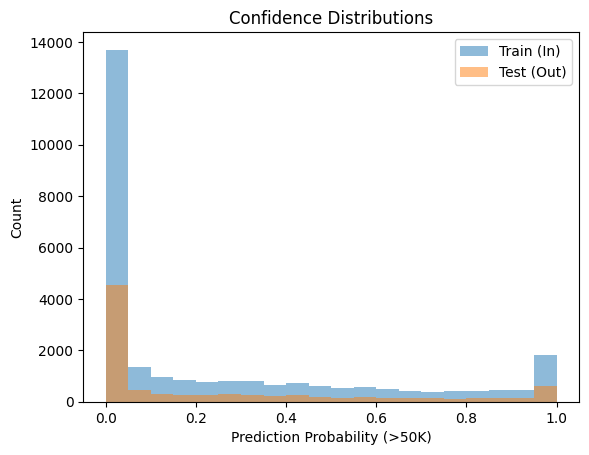

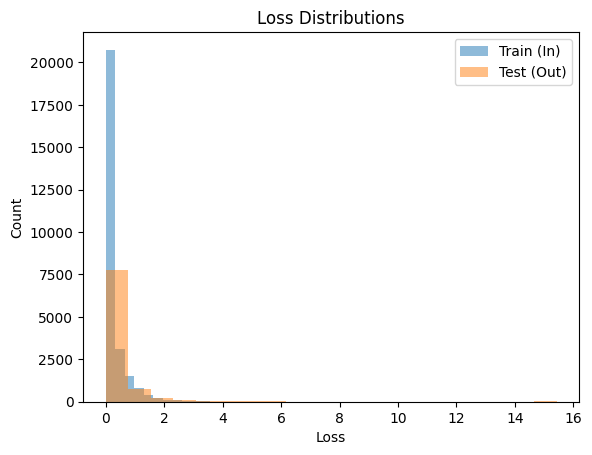

In [25]:
# Train attack model
attack_model = LogisticRegression()
attack_model.fit(attack_X, attack_y)
target_X = np.vstack([train_outputs, test_outputs])
target_y = np.hstack([np.ones(len(train_outputs)), np.zeros(len(test_outputs))])
attack_preds = attack_model.predict(target_X)

# Evaluate
accuracy = accuracy_score(target_y, attack_preds)
precision = precision_score(target_y, attack_preds)
recall = recall_score(target_y, attack_preds)
print(f"Attack Accuracy: {accuracy:.4f}")
print(f"Attack Precision: {precision:.4f}")
print(f"Attack Recall: {recall:.4f}")

# Visuals
cm = confusion_matrix(target_y, attack_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

plt.hist(target_X[target_y == 1][:, 0], bins=20, alpha=0.5, label="Train (In)")
plt.hist(target_X[target_y == 0][:, 0], bins=20, alpha=0.5, label="Test (Out)")
plt.xlabel("Prediction Probability (>50K)")
plt.ylabel("Count")
plt.title("Confidence Distributions")
plt.legend()
plt.savefig("confidence_histogram.png")
plt.show()

plt.hist(target_X[target_y == 1][:, 2], bins=20, alpha=0.5, label="Train (In)")
plt.hist(target_X[target_y == 0][:, 2], bins=20, alpha=0.5, label="Test (Out)")
plt.xlabel("Loss")
plt.ylabel("Count")
plt.title("Loss Distributions")
plt.legend()
plt.savefig("loss_histogram.png")
plt.show()

In [26]:
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 845.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Using device: cpu


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 0, Avg Loss: 1.0991, Epsilon: 0.92
Epoch 5, Avg Loss: 0.8615, Epsilon: 1.71
Epoch 10, Avg Loss: 0.8524, Epsilon: 2.24
Epoch 15, Avg Loss: 0.8295, Epsilon: 2.68
DP Test Accuracy: 0.8270
DP Attack Accuracy: 0.6592


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


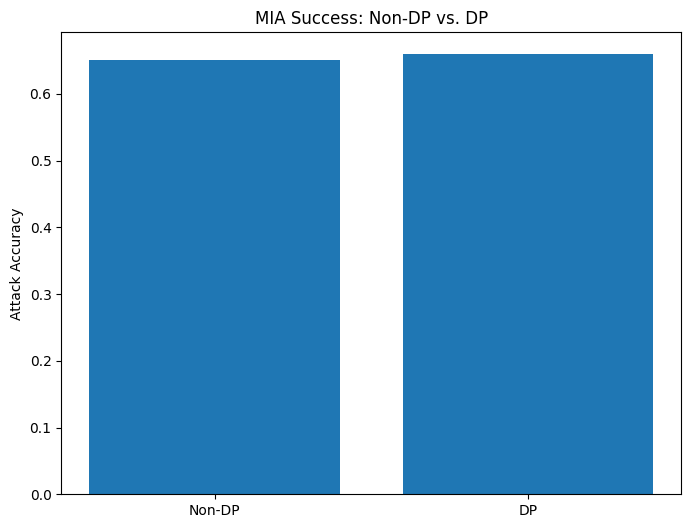

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from opacus import PrivacyEngine
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Define model
class DPModel(nn.Module):
    def __init__(self, input_dim):
        super(DPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

dp_model = DPModel(input_dim=X_train.shape[1]).to(device)

# Optimizer
optimizer = optim.Adam(dp_model.parameters(), lr=0.01)

# Privacy engine
privacy_engine = PrivacyEngine()
dp_model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=dp_model,
    optimizer=optimizer,
    data_loader=train_loader,
    target_epsilon=3.0,
    target_delta=1e-5,
    max_grad_norm=1.0,
    epochs=20
)

# Training loop
epochs = 20
for epoch in range(epochs):
    dp_model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = dp_model(x_batch)
        loss = nn.BCELoss()(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        epsilon = privacy_engine.get_epsilon(delta=1e-5)
        print(f"Epoch {epoch}, Avg Loss: {total_loss / len(train_loader):.4f}, Epsilon: {epsilon:.2f}")

# Evaluate
dp_model.eval()
with torch.no_grad():
    test_outputs = dp_model(X_test_tensor)
    test_accuracy = accuracy_score(y_test, (test_outputs.cpu().numpy() > 0.5).astype(int))
print(f"DP Test Accuracy: {test_accuracy:.4f}")

# DP attack
dp_train_preds = dp_model(X_train_tensor).detach().cpu().numpy().flatten()  # Ensure 1D
dp_test_preds = dp_model(X_test_tensor).detach().cpu().numpy().flatten()   # Ensure 1D
y_train_np = y_train.to_numpy().flatten()  # Convert Series to numpy, 1D
y_test_np = y_test.to_numpy().flatten()    # Convert Series to numpy, 1D

# Compute binary cross-entropy loss element-wise
dp_train_loss = -(
    y_train_np * np.log(dp_train_preds + 1e-7) +
    (1 - y_train_np) * np.log(1 - dp_train_preds + 1e-7)
)
dp_test_loss = -(
    y_test_np * np.log(dp_test_preds + 1e-7) +
    (1 - y_test_np) * np.log(1 - dp_test_preds + 1e-7)
)

# Stack outputs
dp_train_outputs = np.hstack([
    dp_train_preds.reshape(-1, 1),
    (1 - dp_train_preds).reshape(-1, 1),
    dp_train_loss.reshape(-1, 1)
])
dp_test_outputs = np.hstack([
    dp_test_preds.reshape(-1, 1),
    (1 - dp_test_preds).reshape(-1, 1),
    dp_test_loss.reshape(-1, 1)
])
dp_target_X = np.vstack([dp_train_outputs, dp_test_outputs])
dp_target_y = np.hstack([np.ones(len(dp_train_outputs)), np.zeros(len(dp_test_outputs))])
dp_attack_preds = attack_model.predict(dp_target_X)
dp_accuracy = accuracy_score(dp_target_y, dp_attack_preds)
print(f"DP Attack Accuracy: {dp_accuracy:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.bar(["Non-DP", "DP"], [accuracy, dp_accuracy])
plt.ylabel("Attack Accuracy")
plt.title("MIA Success: Non-DP vs. DP")
plt.savefig("dp_comparison.png")
plt.show()